In [1]:
import torchvision
import torch
import pydicom as dicom

import numpy as np
import pandas as pd
from functools import partial
import rnsa
import rnsa_data
from sklearn import metrics
import pytorch_lightning as pl
from pytorch_lightning.trainer.trainer import Trainer

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# %load_ext autoreload
# %autoreload 2

In [12]:
model_path = '/home/tstrebel/models/rnsa/baseline-v2.2.ckpt'
img_dir = '/home/tstrebel/assets/rnsa-pneumonia/train-images'
target_file_path = '/home/tstrebel/assets/rnsa-pneumonia'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

training_data_target_dict = rnsa_data.get_training_data_target_dict(target_file_path)
df_test = training_data_target_dict['df_test']
del training_data_target_dict

test_dataset = rnsa_data.get_dataset(img_dir, df_test)
test_data_loader = rnsa_data.get_data_loader(test_dataset, batch_size=32)

model_dict = torch.load(model_path)

if 'state_dict' in model_dict:
    model = rnsa.Densenet121()
    model.load_state_dict(model_dict['state_dict'])
else:
    model = model_dict['model']

model = model.to(device)

,patientId,x,y,width,height,Target
17264,adfda830-4f01-47d0-adad-0f749cbe68ae,NaN,NaN,NaN,NaN,0
10644,73a993d6-3f86-447d-bfb8-9dbf87be0a66,NaN,NaN,NaN,NaN,0
24146,ea5f9e4f-2005-4588-9c2c-39ef89731993,NaN,NaN,NaN,NaN,0
19505,c244f974-2859-4a60-910b-29061d94252b,NaN,NaN,NaN,NaN,0
1731,17bd6f06-c2f5-4640-bfa3-b3777a6a1a0a,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...
14730,982fcd52-e4b7-4262-8361-069ca0c12148,NaN,NaN,NaN,NaN,0
3842,393997ca-ea3a-4b78-b166-820100faf1cc,NaN,NaN,NaN,NaN,0
5155,44c04e16-3ebf-4f89-ba55-1ce829f7112f,NaN,NaN,NaN,NaN,0
11455,7ad8a73d-d27f-4381-aad9-bda798e87fd5,NaN,NaN,NaN,NaN,0


In [4]:
with torch.no_grad():
    running_targets = torch.Tensor(0, 1).to(device)
    running_outputs = torch.Tensor(0, 1).to(device)
    
    model.eval()
    for inputs, targets in test_data_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        
        running_targets = torch.vstack((running_targets, targets))
        running_outputs = torch.vstack((running_outputs, outputs)) 

best threshold	0.4204
accuracy:	0.8347
precision:	0.6250
recall:		0.6653
f1:		0.6445



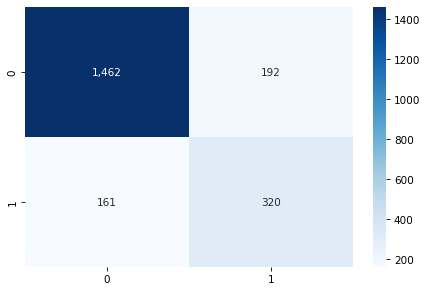

In [5]:
y_true = running_targets.cpu().numpy()
y_proba = torch.sigmoid(running_outputs).cpu().numpy()

fpr, tpr, roc_thresholds = metrics.roc_curve(y_true, y_proba)
g_means = np.sqrt(tpr * (1-fpr))

precision, recall, pr_thresholds = metrics.precision_recall_curve(y_true, y_proba)
f1_scores = (2 * precision * recall) / (precision + recall)

ix = np.argmax(f1_scores)
best_thresh = pr_thresholds[ix]
# ix = np.argmax(g_means)
# best_thresh = roc_thresholds[ix]

y_pred = y_proba >= best_thresh

accuracy_score = metrics.accuracy_score(y_true, y_pred)
precision_score = metrics.precision_score(y_true, y_pred)
recall_score = metrics.recall_score(y_true, y_pred)
f1_score = metrics.f1_score(y_true, y_pred)

print('best threshold\t{:.4f}'.format(best_thresh))
print('accuracy:\t{:.4f}'.format(accuracy_score))
print('precision:\t{:.4f}'.format(precision_score))
print('recall:\t\t{:.4f}'.format(recall_score))
print('f1:\t\t{:.4f}'.format(f1_score))
print()

fig = plt.figure(dpi=75)
ax = plt.gca()
sns.heatmap(metrics.confusion_matrix(y_true, y_pred), annot=True, fmt=',', cmap='Blues')
fig.tight_layout()
plt.show()

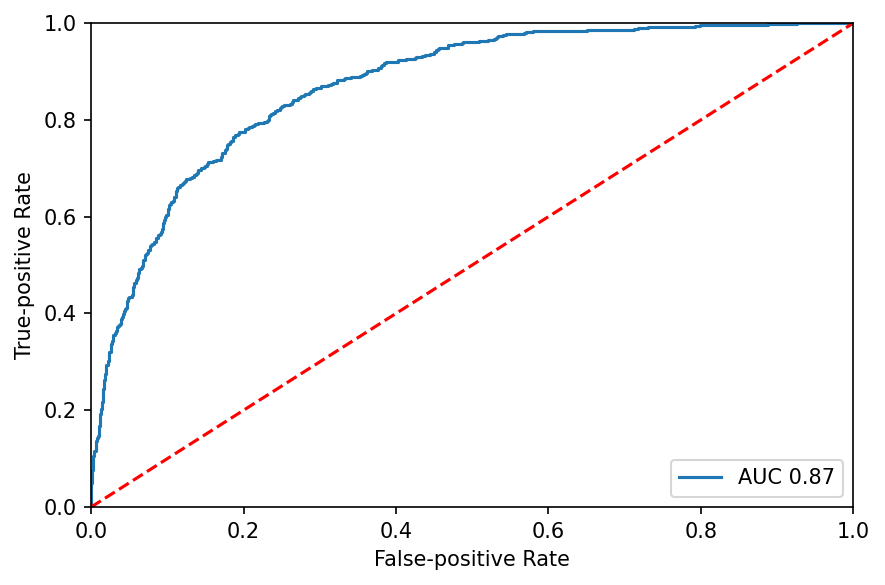

In [6]:
roc_auc_score = metrics.roc_auc_score(y_true, y_proba)

no_skill = np.linspace(0, 1, 100)

plt.figure(dpi=150)
plt.plot(fpr, tpr, label='AUC {:.2f}'.format(roc_auc_score))
plt.plot(no_skill, no_skill, '--r')
plt.legend(loc='lower right')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.ylabel('True-positive Rate')
plt.xlabel('False-positive Rate')
plt.tight_layout()
plt.show()

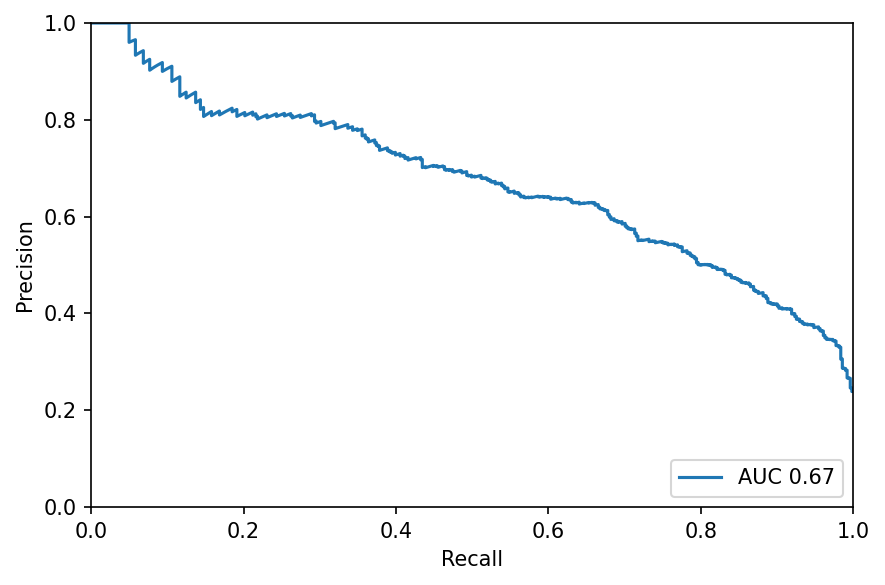

In [7]:
precision, recall, _ = metrics.precision_recall_curve(y_true, y_proba)
auprc_score = metrics.auc(recall, precision)

plt.figure(dpi=150)
plt.plot(recall, precision, label='AUC {:.2f}'.format(auprc_score))
plt.legend(loc='lower right')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.tight_layout()
plt.show()